<a href="https://colab.research.google.com/github/quantbrasil/youtube/blob/master/src/004_Linear_Regression_with_Stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quant 101: Regressão Linear

Neste notebook, vamos explorar os fundamentos da regressão linear usando dados do mercado de ações. A regressão linear é uma das ferramentas mais simples e poderosas no arsenal de um cientista de dados/analista quantitativo, tornando-a uma escolha perfeita para iniciantes.

Vamos aprender a:

1. Visualizar o relacionamento entre duas ações através do gráfico de _scatter plot_;
2. Construir a intuição por trás da regressão linear;
3. Implementar um simples de regressão linear com uma ou mais variáveis;
4. Interpretar os resultados

In [187]:
%%capture
%pip install yfinance==0.2.54

In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for our plots
sns.set_style('whitegrid')

## Baixando os dados de ações

Vamos utilizar o Yahoo Finance para baixar os dados de duas ações, **PETR4** e **ITUB4**. Para ver um vídeo exclusivo sobre o uso da biblioteca `yfinance`, veja o vídeo abaixo:

<iframe width="560" height="315" src="https://www.youtube.com/embed/D8P6X3dKXUM" 
        title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; 
        clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen>
</iframe>

In [189]:
import yfinance as yf

period = "2y"

# Create Ticker objects
ticker_1 = yf.Ticker('PETR4.SA')
ticker_2 = yf.Ticker('ITUB4.SA')

# Get historical data using the history method
df1 = ticker_1.history(period=period)
df2 = ticker_2.history(period=period)

# Look at the PETR4 data
df1.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-02-27 00:00:00-03:00,16.298765,16.866446,16.279841,16.494299,76250600,0.0,0.0
2023-02-28 00:00:00-03:00,16.532144,16.979982,15.920310,15.920310,130248100,0.0,0.0
2023-03-01 00:00:00-03:00,15.964466,16.040158,15.258019,15.958158,109257700,0.0,0.0
2023-03-02 00:00:00-03:00,16.033846,16.191535,15.371551,15.541855,124516200,0.0,0.0
2023-03-03 00:00:00-03:00,15.661698,16.235687,15.422011,16.210457,87591800,0.0,0.0


Agora, vamos preparar nossos dados para análise. Vamos focar nos preços de fechamento e calcular os retornos diários de ambas as ações.

In [190]:
# Create a new dataframe with just the closing prices
stocks_data = pd.DataFrame({
    'PETR4': df1['Close'],
    'ITUB4': df2['Close']
})

# Calculate daily returns (percentage change)
returns_data = stocks_data.pct_change().dropna()

# Show the first few rows of both dataframes
print("Closing Prices:")
print(stocks_data.head())
print("\nDaily Returns:")
print(returns_data.head())

Closing Prices:
                               PETR4      ITUB4
Date                                           
2023-02-27 00:00:00-03:00  16.494299  21.530708
2023-02-28 00:00:00-03:00  15.920310  21.607176
2023-03-01 00:00:00-03:00  15.958158  21.256569
2023-03-02 00:00:00-03:00  15.541855  20.559355
2023-03-03 00:00:00-03:00  16.210457  20.584864

Daily Returns:
                              PETR4     ITUB4
Date                                         
2023-02-28 00:00:00-03:00 -0.034799  0.003552
2023-03-01 00:00:00-03:00  0.002377 -0.016226
2023-03-02 00:00:00-03:00 -0.026087 -0.032800
2023-03-03 00:00:00-03:00  0.043019  0.001241
2023-03-06 00:00:00-03:00  0.010117  0.022718


## Visualizando o Scatter Plot

Antes de entendermos a regressão linear, vamos visualizar o relacionamento entre as duas ações usando um gráfico de dispersão (_scatter plot_). Isso ajuda-nos a entender se pode haver um relacionamento linear que valha a pena modelar.

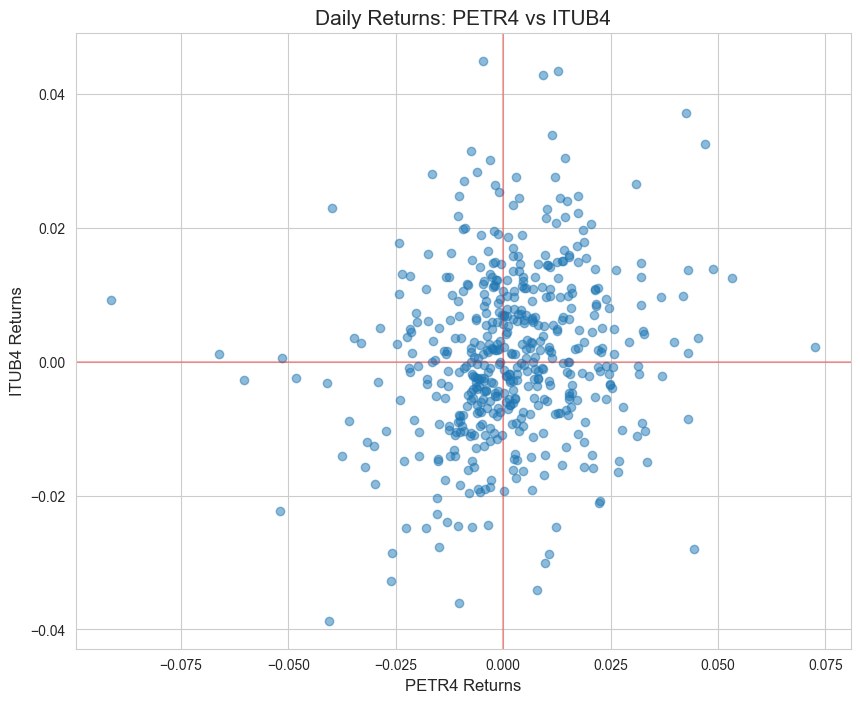

In [191]:
plt.figure(figsize=(10, 8))
plt.scatter(returns_data['PETR4'], returns_data['ITUB4'], alpha=0.5)
plt.title('Daily Returns: PETR4 vs ITUB4', fontsize=15)
plt.xlabel('PETR4 Returns', fontsize=12)
plt.ylabel('ITUB4 Returns', fontsize=12)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='r', linestyle='-', alpha=0.3)
plt.grid(True)
plt.show()

### Entendendo os Scatter Plots

O _scatter plot_ acima mostra cada dia como um ponto, onde:
- O eixo x representa o retorno diário de PETR4
- O eixo y representa o retorno diário de ITUB4

Se houver uma relação positiva entre as ações, esperaríamos ver os pontos formando um padrão do canto inferior esquerdo ao canto superior direito. Isso significaria que, quando a PETR4 sobe, a ITUB4 também tende a subir.

Vamos verificar como o **preço** de cada ação varia com o tempo:

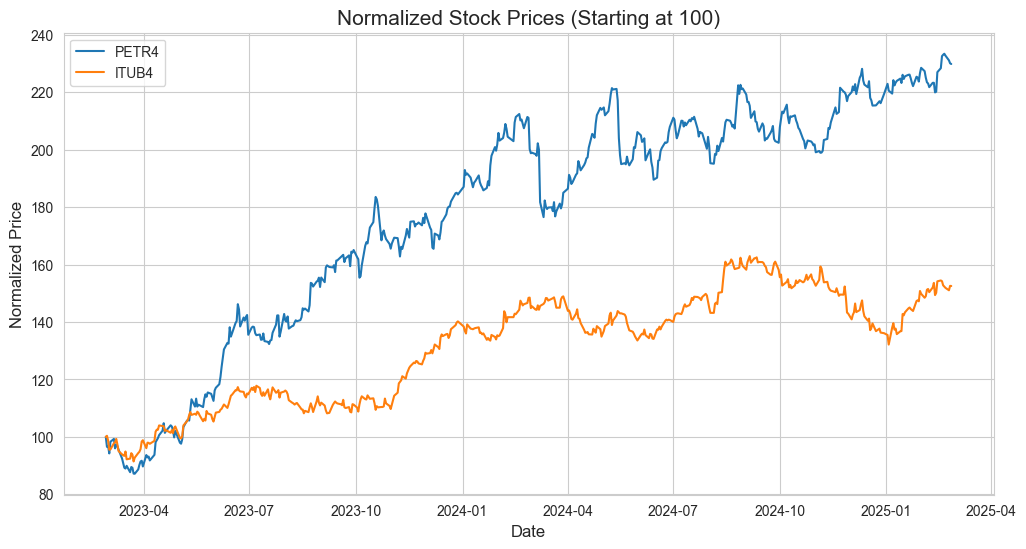

In [192]:
# Normalize prices to start at 100 for easier comparison
normalized_prices = stocks_data / stocks_data.iloc[0] * 100

plt.figure(figsize=(12, 6))
plt.plot(normalized_prices.index, normalized_prices['PETR4'], label='PETR4')
plt.plot(normalized_prices.index, normalized_prices['ITUB4'], label='ITUB4')
plt.title('Normalized Stock Prices (Starting at 100)', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Normalized Price', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

## Calculando a Regressão Linear

A regressão linear consiste em encontrar a linha reta de "melhor ajuste" através de um conjunto de pontos.

### Intuição

Imagine que você tenha pontos dispersos em um gráfico (como nosso gráfico de dispersão de retornos acima). O objetivo da regressão linear é desenhar uma linha reta que esteja o mais próximo possível de todos esses pontos.
 
A equação dessa linha é tipicamente escrita como:

$$y = \beta x + \alpha$$

Where:
- $y$ é a variável _dependente_ (o que estamos tentando prever, no caso os retornos de ITUB4)
- $x$ é a variável _independente_ (o que estamos usando para fazer a previsões, no caso os retornos de PETR4)
- $\beta$ é a inclinação (quanto $y$ muda quando $x$ aumenta em 1, também chamado de _coeficiente angular_)
- $\alpha$ é o valor de $y$ quando $x = 0$ (também chamado de _constante_, ou _coeficiente linear_)

No contexto de ações:
- If $\beta > 0$: Tendem a se mover na mesma direção (correlação positiva)
- If $\beta < 0$: Tendem a se mover em direções opostas (correlação negativa)
- A magnitude do $\beta$ nos dá a força com a qual o retorno de uma ação influencia na outra

Vamos implementar um modelo simples de regressão linear para ver isso na prática.

In [193]:
# Prepare the data for regression
X = returns_data['PETR4'].values.reshape(-1, 1)  # Independent variable
y = returns_data['ITUB4'].values  # Dependent variable

# The .reshape(-1, 1) transforms the data from a 1D array to a 2D array with one column
# This is required by scikit-learn, which expects a 2D array for the independent variable

print(X.shape)
print(y.shape)

print(X[:5])
print(y[:5])


(500, 1)
(500,)
[[-0.03479923]
 [ 0.00237737]
 [-0.0260872 ]
 [ 0.04301945]
 [ 0.01011702]]
[ 0.00355156 -0.01622641 -0.03279994  0.00124074  0.02271766]


In [194]:
from sklearn.linear_model import LinearRegression

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Get the coefficient (slope) and intercept
best_slope = model.coef_[0]
best_intercept = model.intercept_

print(f"Linear Regression Equation: ITUB4_return = {best_slope:.4f} × PETR4_return + {best_intercept:.4f}")

Linear Regression Equation: ITUB4_return = 0.1291 × PETR4_return + 0.0007


Agora, vamos visualizar nossa linha de regressão sobre o gráfico de dispersão para ver quão bem ela se ajusta aos dados:

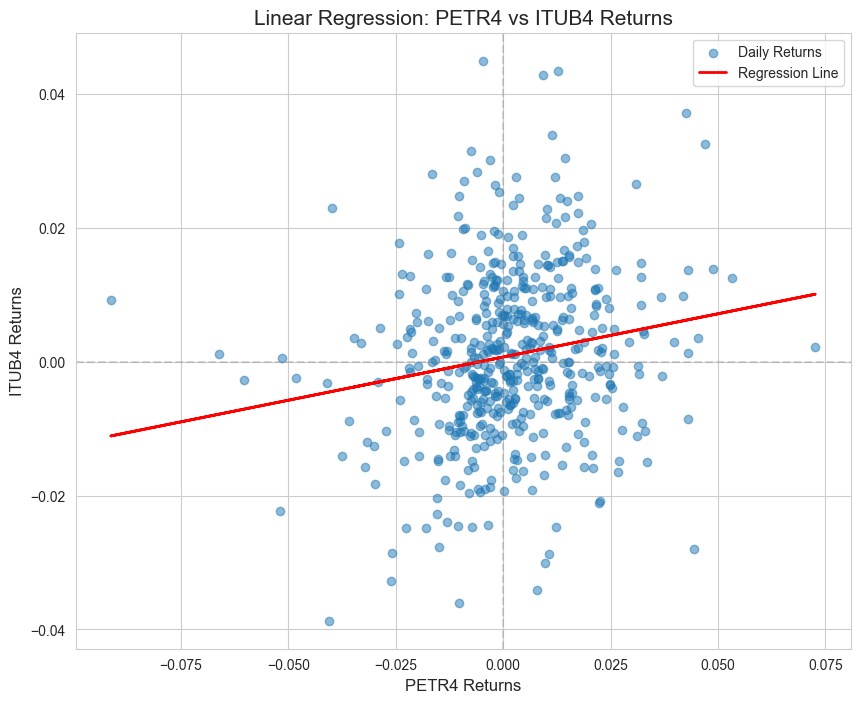

In [195]:
# Make predictions using our model
y_pred = model.predict(X)

# Create the scatter plot with regression line
plt.figure(figsize=(10, 8))

# Plot the actual data points
plt.scatter(X, y, alpha=0.5, label='Daily Returns')

# Plot the regression line
plt.plot(X, y_pred, color='red', linewidth=2, label='Regression Line')

plt.title('Linear Regression: PETR4 vs ITUB4 Returns', fontsize=15)
plt.xlabel('PETR4 Returns', fontsize=12)
plt.ylabel('ITUB4 Returns', fontsize=12)
plt.axhline(y=0, color='grey', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='grey', linestyle='--', alpha=0.3)
plt.grid(True)
plt.legend()
plt.show()

## 4. Como a Regressão Linear encontra a "Melhor Linha"

Quando temos pontos dispersos no gráfico (como os retornos das ações), existem infinitas linhas que poderíamos traçar. Como encontramos a _melhor_ delas?

Vamos visualizar algumas linhas candidatas, com diferentes coeficientes angular e linear.

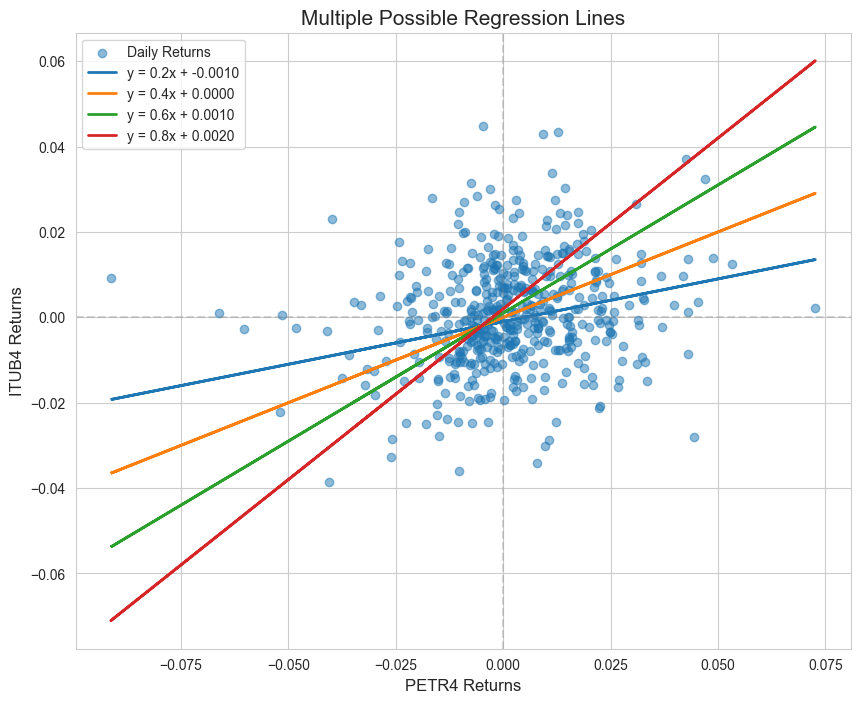

In [196]:
# Plot several possible regression lines
plt.figure(figsize=(10, 8))

# Plot the actual data points
plt.scatter(X, y, alpha=0.5, label='Daily Returns')

# Plot several possible regression lines
slopes = [0.2, 0.4, 0.6, 0.8]
intercepts = [-0.001, 0, 0.001, 0.002]

for s, i in zip(slopes, intercepts):
    # X is a 2D array (shape n x 1), but we need a 1D array for element-wise multiplication
    # .flatten() converts the 2D array to a 1D array, allowing proper broadcasting with scalar s
    y_line = s * X.flatten() + i
    plt.plot(X, y_line, linewidth=2, label=f'y = {s:.1f}x + {i:.4f}')

plt.title('Multiple Possible Regression Lines', fontsize=15)
plt.xlabel('PETR4 Returns', fontsize=12)
plt.ylabel('ITUB4 Returns', fontsize=12)
plt.axhline(y=0, color='grey', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='grey', linestyle='--', alpha=0.3)
plt.grid(True)
plt.legend()
plt.show()

### Entendendo os Resíduos: A Chave para Encontrar a Melhor Linha

O "resíduo" é a diferença entre o valor real e o valor previsto pelo nosso modelo. Visualmente, é a distância _vertical_ entre um ponto de dados e a linha de regressão.

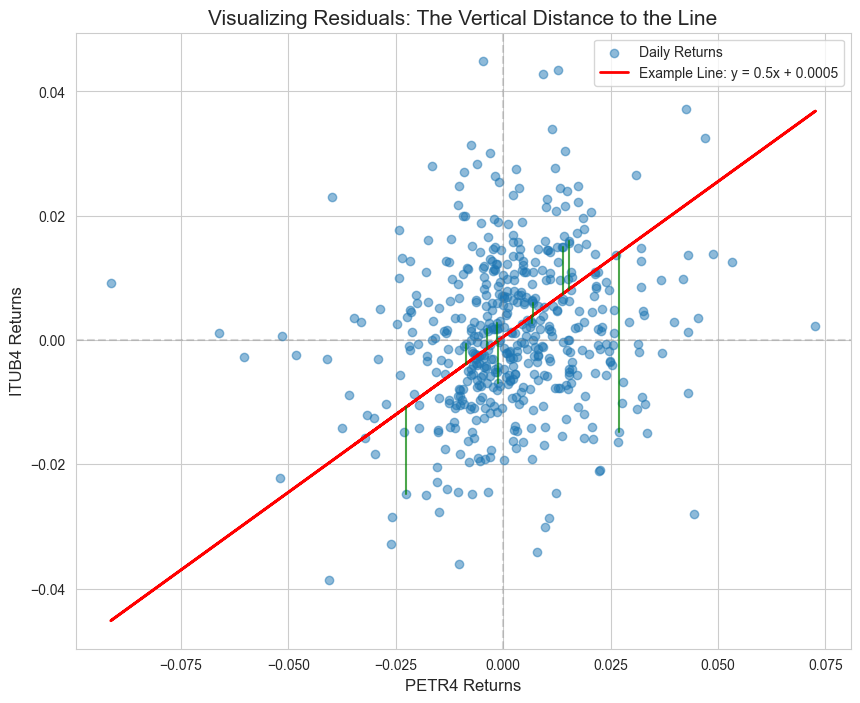

In [197]:
# Let's visualize residuals for a single possible regression line
plt.figure(figsize=(10, 8))

# Choose one possible line (not necessarily the best one)
example_slope = 0.5
example_intercept = 0.0005

# Calculate predictions with this line
example_predictions = example_slope * X.flatten() + example_intercept

# Plot the data and the line
plt.scatter(X, y, alpha=0.5, label='Daily Returns')
plt.plot(X, example_predictions, color='red', linewidth=2, 
         label=f'Example Line: y = {example_slope:.1f}x + {example_intercept:.4f}')

# Plot some residuals as vertical lines
indices = np.random.choice(len(X), 10, replace=False)  # Select random points
for i in indices:
    x_val = X[i][0]
    actual = y[i]
    predicted = example_slope * x_val + example_intercept
    residual = actual - predicted
    
    # Draw the vertical line representing the residual
    plt.plot([x_val, x_val], [predicted, actual], 'g-', alpha=0.7)

plt.title('Visualizing Residuals: The Vertical Distance to the Line', fontsize=15)
plt.xlabel('PETR4 Returns', fontsize=12)
plt.ylabel('ITUB4 Returns', fontsize=12)
plt.axhline(y=0, color='grey', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='grey', linestyle='--', alpha=0.3)
plt.grid(True)
plt.legend()
plt.show()

### Método dos Mínimos Quadrados (OLS): Minimizando a Soma dos Quadrados dos Resíduos

A regressão linear encontra a linha que minimiza a soma do quadrado dos resíduos. Elevamos ao quadrado pois:

A regressão linear encontra a linha que minimiza a soma dos quadrados dos resíduos. Por que quadrados? Porque:

- Torna todos valores positivos (evitando que erros positivos e negativos se anulem)
- Penaliza erros maiores
- Possui propriedades matemáticas que tornam mais fácil encontrar o mínimo

Vamos visualizar como linhas diferentes possuem erros diferentes:

In [198]:
# Function to calculate total squared error for a given line
def calculate_squared_error(slope, intercept, X, y):
    predictions = slope * X + intercept
    residuals = y - predictions
    squared_residuals = residuals ** 2
    return np.sum(squared_residuals)

In [199]:
# Create a grid of potential slopes and intercepts
test_slopes = np.linspace(0.3, 0.7, 5)
test_intercepts = np.linspace(-0.001, 0.002, 5)

print(test_slopes)
print(test_intercepts)

[0.3 0.4 0.5 0.6 0.7]
[-0.001   -0.00025  0.0005   0.00125  0.002  ]


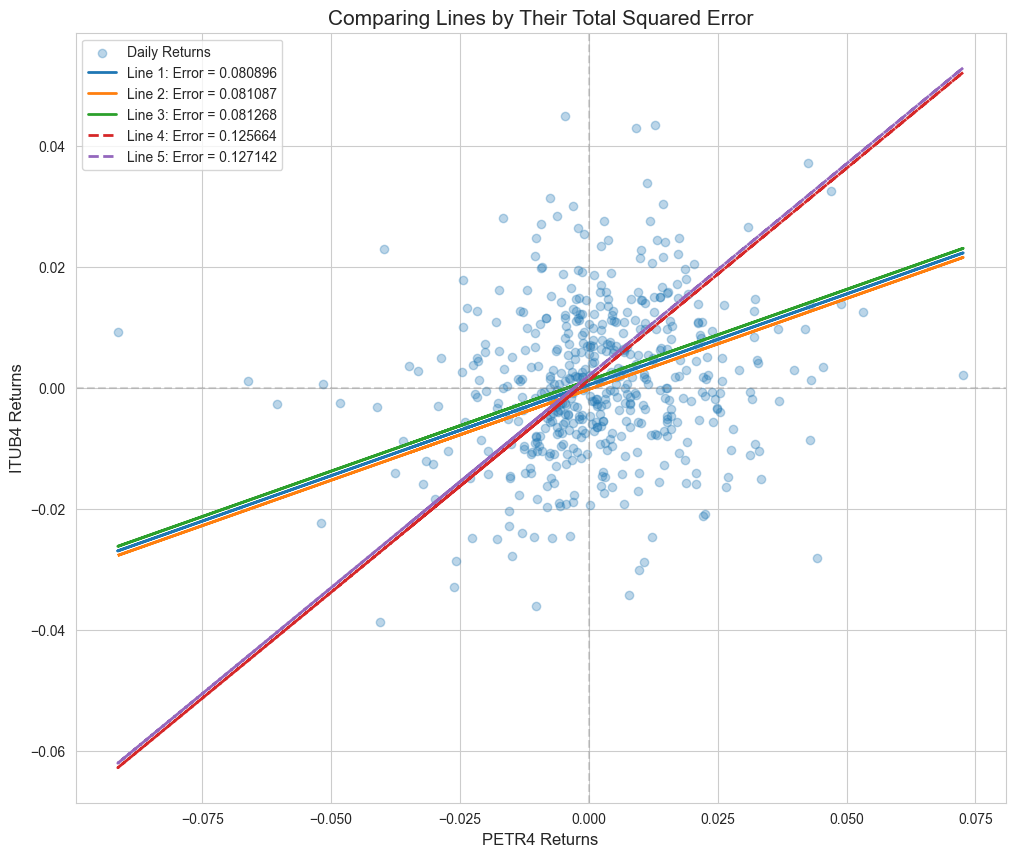

In [200]:
total_errors = []

# Plot to compare a few different lines and their total errors
plt.figure(figsize=(12, 10))

for slope in test_slopes:
    for intercept in test_intercepts:
        # Calculate total squared error
        total_error = calculate_squared_error(slope, intercept, X.flatten(), y)
        total_errors.append((slope, intercept, total_error))

# Sort by error and select a few to visualize
sorted_errors = sorted(total_errors, key=lambda x: x[2])

# Plot the top 3 (best) and bottom 2 (worst) lines
plt.scatter(X, y, alpha=0.3, label='Daily Returns')

# Plot best lines
for i, (slope, intercept, error) in enumerate(sorted_errors[:3]):
    predictions = slope * X + intercept
    plt.plot(X, predictions, linewidth=2, 
             label=f'Line {i+1}: Error = {error:.6f}')

# Plot worst lines
for i, (slope, intercept, error) in enumerate(sorted_errors[-2:]):
    predictions = slope * X + intercept
    plt.plot(X, predictions, linewidth=2, linestyle='--',
             label=f'Line {i+4}: Error = {error:.6f}')

plt.title('Comparing Lines by Their Total Squared Error', fontsize=15)
plt.xlabel('PETR4 Returns', fontsize=12)
plt.ylabel('ITUB4 Returns', fontsize=12)
plt.axhline(y=0, color='grey', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='grey', linestyle='--', alpha=0.3)
plt.grid(True)
plt.legend()
plt.show()

### A Matemática por trás da Regressão Linear

Quando chamamos `model.fit()` na biblioteca do `scikit-learn`, calculamos o $\beta$ e o $\alpha$ através das seguintes fórmulas:

$$
\beta = \frac{\sum[(x_i - \bar{x})(y_i - \bar{y})]}{\sum[(x_i - \bar{x})^2]}
$$

$$
\alpha = \bar{y} - \beta \cdot \bar{x}
$$

Onde:
- $x_i$ e $y_i$ são cada _data point_
- $\bar{x}$ e $\bar{y}$ são as médias de $x$ e $y$

Podemos verificar esse fato calculando os coeficientes manualmente:

In [201]:
# Calculate slope and intercept manually
x_data = X.flatten()
y_data = y

x_mean = np.mean(x_data)
y_mean = np.mean(y_data)

# Calculate numerator: sum of (x_i - x_mean) * (y_i - y_mean)
numerator = np.sum((x_data - x_mean) * (y_data - y_mean))

# Calculate denominator: sum of (x_i - x_mean)²
denominator = np.sum((x_data - x_mean) ** 2)

# Calculate slope and intercept
manual_slope = numerator / denominator
manual_intercept = y_mean - manual_slope * x_mean

print(f"Manually calculated slope: {manual_slope:.4f}")
print(f"Manually calculated intercept: {manual_intercept:.4f}")
print(f"scikit-learn calculated slope: {best_slope:.4f}")
print(f"scikit-learn calculated intercept: {best_intercept:.4f}")

Manually calculated slope: 0.1291
Manually calculated intercept: 0.0007
scikit-learn calculated slope: 0.1291
scikit-learn calculated intercept: 0.0007


### Bônus: Visualizando o Menor Erro no Espaço 3D

Verificamos que chamar o método `.fit()` de fato retorna o mesmo valor que o cálculo manual. Mas como saber que esse erro é _de fato_ o menor?

Podemos intuir através de uma análise visual no espaço tridimensional.

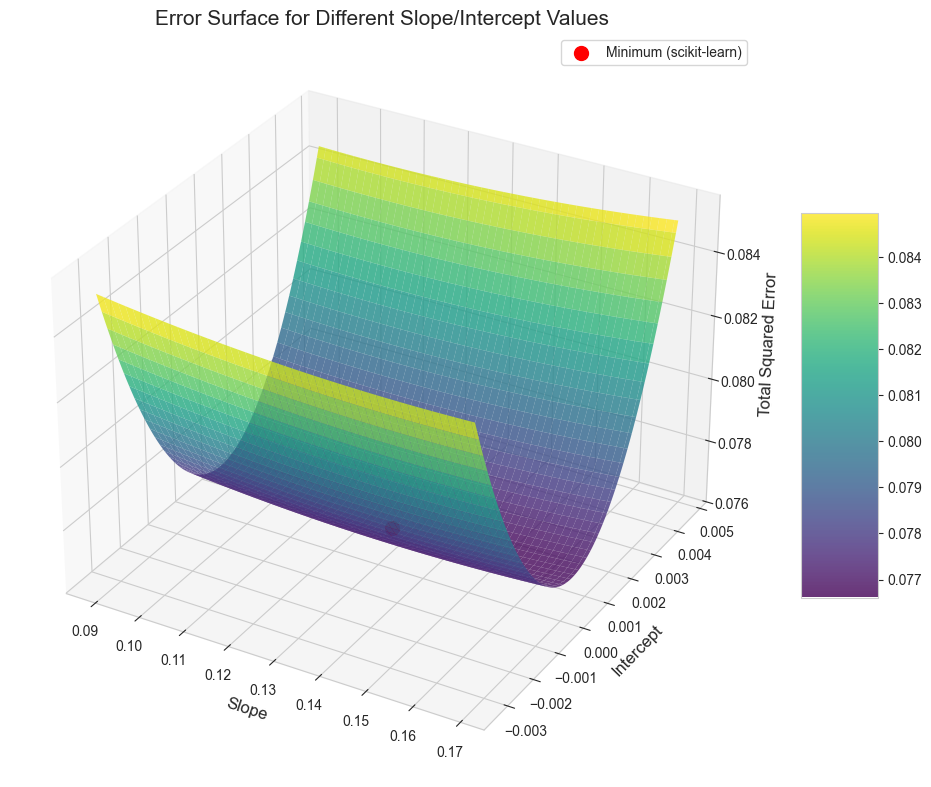

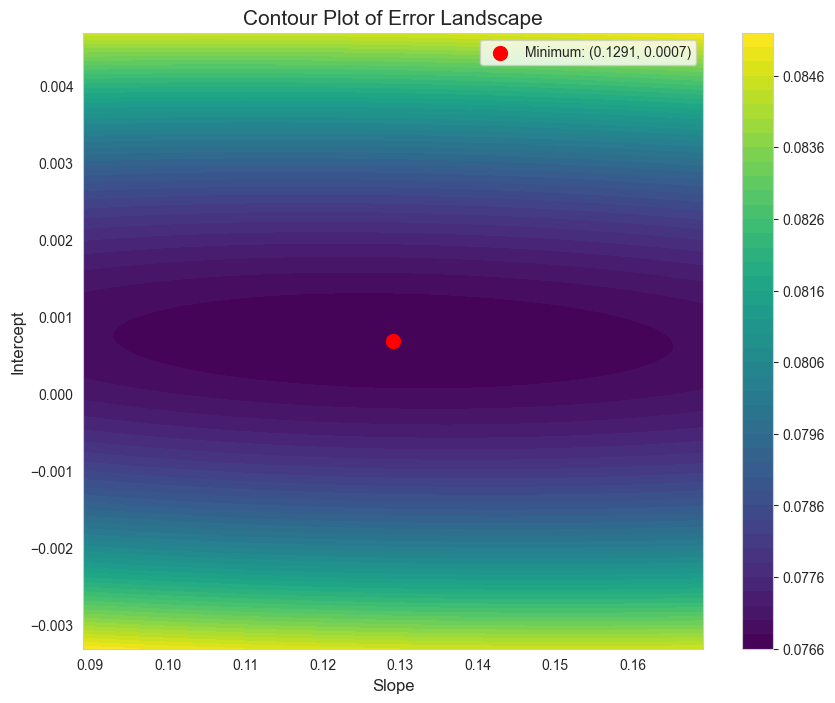

Error at scikit-learn solution (slope=0.1291, intercept=0.0007): 0.0766074102
This should be the minimum error value on the surface


In [202]:
# Create a fine grid of slope and intercept values around our solution
# to create an error surface
margin = 0.04  # Explore around the solution
num_points = 100  # More points for a smoother surface

# Create a grid centered around the scikit-learn solution
fine_slopes = np.linspace(best_slope - margin, best_slope + margin, num_points)
fine_intercepts = np.linspace(best_intercept - margin/10, best_intercept + margin/10, num_points)

# Calculate error for each point in the grid
error_grid = np.zeros((len(fine_slopes), len(fine_intercepts)))

for i, slope in enumerate(fine_slopes):
    for j, intercept in enumerate(fine_intercepts):
        error_grid[i, j] = calculate_squared_error(slope, intercept, X.flatten(), y)

# Create a meshgrid for plotting
slope_grid, intercept_grid = np.meshgrid(fine_slopes, fine_intercepts)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the error surface
surf = ax.plot_surface(slope_grid, intercept_grid, error_grid.T, 
                      cmap='viridis', alpha=0.8, edgecolor='none')

# Mark the minimum point (scikit-learn solution)
ax.scatter([best_slope], [best_intercept], 
           [calculate_squared_error(best_slope, best_intercept, X.flatten(), y)],
           color='red', s=100, label='Minimum (scikit-learn)')

# Calculate the error at our solution
min_error = calculate_squared_error(best_slope, best_intercept, X.flatten(), y)

ax.set_xlabel('Slope', fontsize=12)
ax.set_ylabel('Intercept', fontsize=12)
ax.set_zlabel('Total Squared Error', fontsize=12)
ax.set_title('Error Surface for Different Slope/Intercept Values', fontsize=15)

# Add a colorbar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
plt.legend()
plt.show()

# Also create a contour plot for a clearer top-down view
plt.figure(figsize=(10, 8))
contour = plt.contourf(slope_grid, intercept_grid, error_grid.T, 50, cmap='viridis')
plt.colorbar(contour)

# Mark the minimum
plt.scatter([best_slope], [best_intercept], color='red', s=100, 
            label=f'Minimum: ({best_slope:.4f}, {best_intercept:.4f})')

plt.title('Contour Plot of Error Landscape', fontsize=15)
plt.xlabel('Slope', fontsize=12)
plt.ylabel('Intercept', fontsize=12)
plt.legend()
plt.show()

print(f"Error at scikit-learn solution (slope={best_slope:.4f}, intercept={best_intercept:.4f}): {min_error:.10f}")
print("This should be the minimum error value on the surface")

## Analisando o Modelo

Agora que construímos nosso modelo de regressão linear, vamos avaliar quão bem ele se desempenha. Existem várias métricas que podemos usar:

1. **R-squared (R²)**: Mede a proporção da variância na variável dependente que é explicada pela(s) variável(is) independente(s).  
   - R² varia de 0 a 1, onde valores mais altos são melhores  
   - R² = 1 significa que o modelo explica toda a variabilidade  
   - R² = 0 significa que o modelo não explica nenhuma variabilidade  

2. **Mean Squared Error (MSE)**: Mede a diferença quadrática média entre os valores previstos e os valores reais.  
   - Valores menores de MSE indicam melhor ajuste ao modelo

Vamos calcular essas métricas para o nosso modelo:

In [203]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate R-squared
r_squared = r2_score(y, y_pred)

# Calculate Mean Squared Error
mse = mean_squared_error(y, y_pred)

print(f"R-squared (R²): {r_squared:.4f}")
print(f"Mean Squared Error (MSE): {mse:.8f}")

R-squared (R²): 0.0309
Mean Squared Error (MSE): 0.00015321


### Interpretando os Resultados

Vamos interpretar o que nosso modelo está nos dizendo:

1. **A Inclinação (Slope)**: O coeficiente angular (inclinação) indica quanto o retorno da ITUB4 muda quando o retorno da PETR4 aumenta em 1%.

2. **O Coeficience Linear**: Representa o retorno esperado da ITUB4 quando o retorno da PETR4 é 0%.

3. **R-quadrado (R²)**: Indica qual porcentagem da variação nos retornos da ITUB4 pode ser explicada pelos retornos da PETR4.

O que isso significa para os investidores?

- Se houver um relacionamento forte (R² alto) entre as variáveis, uma ação pode ser potencialmente usada para prever a outra
- A inclinação nos dá uma ideia do "beta", ou seja, a sensibilidade de uma ação em relação à outra
- Um R² baixo sugere que outros fatores são mais importantes para determinar os movimentos da ação

5. Exemplo na Prática: Prevendo uma Ação com Outra

Vamos tentar usar nosso modelo para "prever" os retornos da ITUB4 com base nos retornos da PETR4. Iremos dividir nossos dados em conjuntos de treinamento e teste para simular um cenário do mundo real.

In [204]:
# Split data into training (80%) and testing (20%)
train_size = int(len(returns_data) * 0.8)
train_data = returns_data.iloc[:train_size]
test_data = returns_data.iloc[train_size:]

# Prepare training data
X_train = train_data['PETR4'].values.reshape(-1, 1)
y_train = train_data['ITUB4'].values

# Prepare testing data
X_test = test_data['PETR4'].values.reshape(-1, 1)
y_test = test_data['ITUB4'].values

# Train the model on training data
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on test data
y_pred = model.predict(X_test)

# Evaluate the model
test_r2 = r2_score(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)

print(f"Test Set R-squared: {test_r2:.4f}")
print(f"Test Set MSE: {test_mse:.8f}")

Test Set R-squared: 0.0360
Test Set MSE: 0.00018619


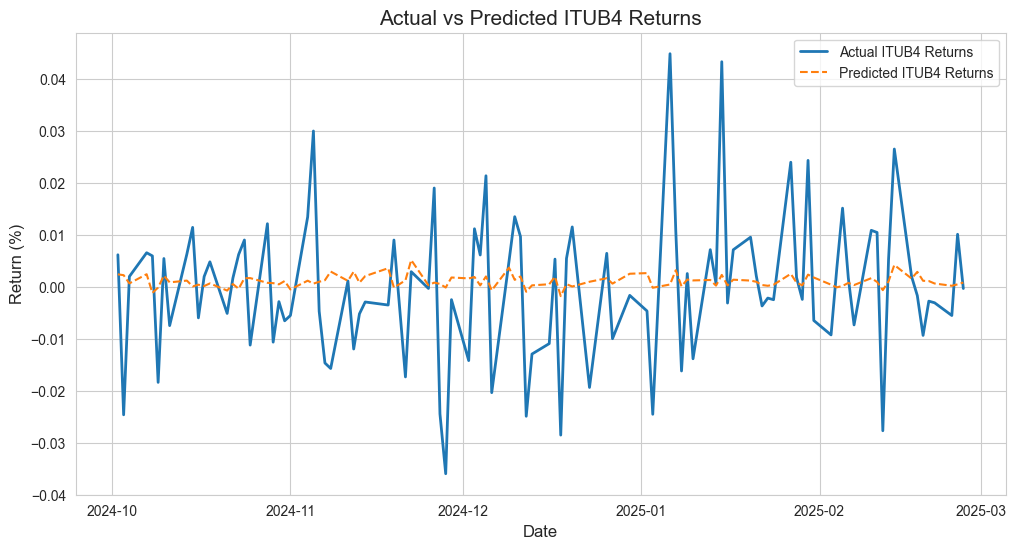

In [205]:
# Let's visualize our predictions vs. actual values
plt.figure(figsize=(12, 6))

# Create a DataFrame with actual and predicted values
results = pd.DataFrame({
    'Date': test_data.index,
    'Actual': y_test,
    'Predicted': y_pred.flatten()
}).set_index('Date')

# Plot actual vs predicted values
plt.plot(results.index, results['Actual'], label='Actual ITUB4 Returns', linewidth=2)
plt.plot(results.index, results['Predicted'], label='Predicted ITUB4 Returns', linewidth=1.5, linestyle='--')

plt.title('Actual vs Predicted ITUB4 Returns', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Return (%)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

## Indo Além: Regressão Linear Multivariada

Até agora, usamos apenas uma ação para prever outra. Na realidade, o movimento de uma ação é influenciado por vários fatores. Podemos estender nossa regressão linear simples para incluir múltiplas variáveis — isso é chamado de regressão linear múltipla.

Vamos adicionar um índice de mercado (Ibovespa) ao nosso modelo para ver se isso melhora nossas previsões.

In [206]:
# Download Ibovespa data using Ticker object
ibov_ticker = yf.Ticker('^BVSP')
ibov = ibov_ticker.history(period=period)

# Add Ibovespa to our dataset
stocks_data['IBOV'] = ibov['Close']
returns_data = stocks_data.pct_change().dropna()

# Split data again
train_size = int(len(returns_data) * 0.8)
train_data = returns_data.iloc[:train_size]
test_data = returns_data.iloc[train_size:]

# Prepare training data with multiple features
X_train_multi = train_data[['PETR4', 'IBOV']].values
y_train = train_data['ITUB4'].values

# Prepare testing data
X_test_multi = test_data[['PETR4', 'IBOV']].values
y_test = test_data['ITUB4'].values

# Train the multiple regression model
multi_model = LinearRegression()
multi_model.fit(X_train_multi, y_train)

# Make predictions
y_pred_multi = multi_model.predict(X_test_multi)

# Evaluate the model
multi_r2 = r2_score(y_test, y_pred_multi)
multi_mse = mean_squared_error(y_test, y_pred_multi)

print("Multiple Regression Coefficients:")
print(f"PETR4: {multi_model.coef_[0]:.4f}")
print(f"IBOV: {multi_model.coef_[1]:.4f}")
print(f"Intercept: {multi_model.intercept_:.4f}")
print(f"\nTest Set R-squared: {multi_r2:.4f} (vs. {test_r2:.4f} for simple regression)")
print(f"Test Set MSE: {multi_mse:.8f} (vs. {test_mse:.8f} for simple regression)")

Multiple Regression Coefficients:
PETR4: -0.1276
IBOV: 1.0524
Intercept: 0.0008

Test Set R-squared: 0.7180 (vs. 0.0360 for simple regression)
Test Set MSE: 0.00005446 (vs. 0.00018619 for simple regression)


### Comparando os Modelos

Vamos visualizar como o modelo linear de múltiplas variáveis (features) se compara com o modelo linear simples:

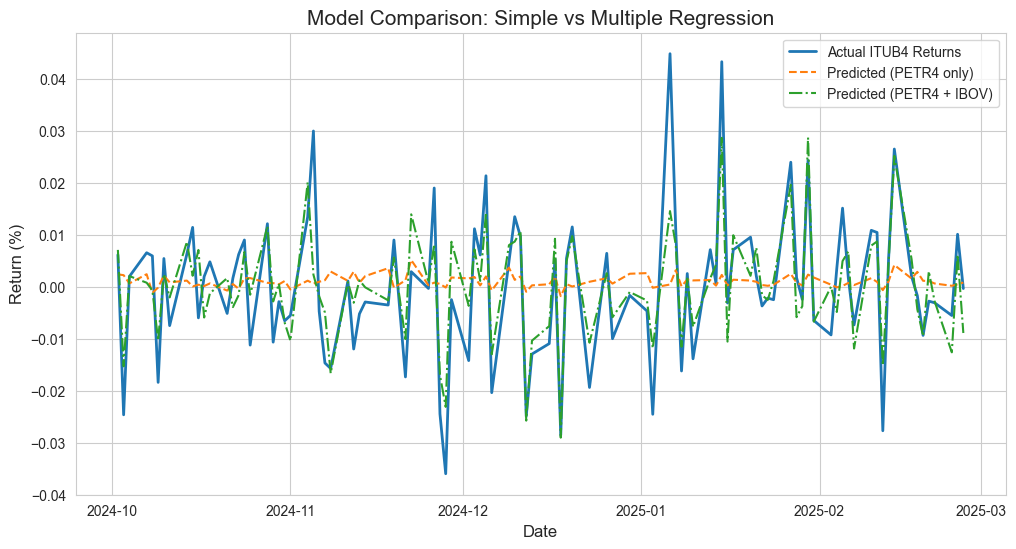

In [207]:
# Create a DataFrame with actual and both sets of predicted values
comparison = pd.DataFrame({
    'Date': test_data.index,
    'Actual': y_test,
    'Simple Model': y_pred.flatten(),
    'Multiple Model': y_pred_multi.flatten()
}).set_index('Date')

plt.figure(figsize=(12, 6))
plt.plot(comparison.index, comparison['Actual'], label='Actual ITUB4 Returns', linewidth=2)
plt.plot(comparison.index, comparison['Simple Model'], label='Predicted (PETR4 only)', linewidth=1.5, linestyle='--')
plt.plot(comparison.index, comparison['Multiple Model'], label='Predicted (PETR4 + IBOV)', linewidth=1.5, linestyle='-.')

plt.title('Model Comparison: Simple vs Multiple Regression', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Return (%)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

## Conclusão

Neste notebook, exploramos a regressão linear com dados de ações, começando pelo básico:

1. Visualizamos relacionamentos entre as ações usando gráficos de dispersão
2. Construímos um modelo de regressão linear simples para prever o retorno de uma ação com base em outra
3. Avaliamos nosso modelo usando métricas como R-quadrado e MSE
4. Estendemos nossa abordagem para regressão linear múltipla adicionando um índice de mercado

### Principais Observações:

- A regressão linear nos ajuda a quantificar relacionamentos entre variáveis
- A inclinação indica o quão sensível uma ação é às mudanças em outra
- O R-quadrado nos diz quanto da variação é explicada pelo nosso modelo
- Adicionar mais variáveis relevantes pode melhorar nossas previsões

### Limitações e Próximos Passos:

- A regressão linear assume um relacionamento linear, o que nem sempre é verdadeiro nos mercados financeiros
- Séries temporais financeiras frequentemente têm propriedades especiais (como autocorrelação) que a regressão linear simples não considera
- Para modelos mais robustos, podemos considerar:
  - Técnicas de análise de séries temporais
  - Modelos de machine learning mais sofisticados
  - Recursos adicionais, como indicadores técnicos ou dados econômicos

A regressão linear é um ponto de partida poderoso para análise quantitativa, mas é apenas o começo do que é possível com ciência de dados e finanças!